In [3]:
import torch
from torch import nn
import math

from sklearn.preprocessing import StandardScaler


In [4]:
# Find what device to work with
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
ens=[torch.rand(10),torch.rand(10)]

In [7]:
torch.stack(ens)

tensor([[0.7225, 0.3041, 0.1289, 0.7356, 0.5725, 0.9177, 0.4071, 0.6804, 0.2379,
         0.7089],
        [0.5517, 0.4859, 0.6030, 0.4225, 0.6662, 0.0266, 0.1302, 0.9302, 0.6602,
         0.5498]])

In [3]:
torch.std_mean(y_train)

NameError: name 'y_train' is not defined

In [15]:
splitting_index=0


In [16]:
def normalize(X_train, y_train, X_test, y_test,device):

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train = torch.as_tensor(scaler_X.fit_transform(X_train)).float().to(device)
    y_train_un=y_train.clone().float().to(device)
    y_train = torch.as_tensor(scaler_y.fit_transform(y_train)).float().to(device)
   
    
    inverse_scaler_y = lambda t: torch.as_tensor(scaler_y.inverse_transform(t.cpu())).to(device)

    X_test = torch.as_tensor(scaler_X.transform(X_test)).float().to(device)
    y_test_un=y_test.float().to(device)
    return X_train, y_train, y_train_un, X_test, y_test_un,  inverse_scaler_y

def get_data(splitting_index,device):
    X_train = torch.load('data/boston_X_train_('+str(splitting_index)+').pt')
    y_train = torch.load('data/boston_y_train_('+str(splitting_index)+').pt')
    X_test = torch.load('data/boston_X_test_('+str(splitting_index)+').pt')
    y_test=torch.load('data/boston_y_test_('+str(splitting_index)+').pt')
    return normalize(X_train, y_train, X_test, y_test,device)


In [17]:
X_train, y_train, y_train_un, X_test, y_test_un, inverse_scaler_y = get_data(splitting_index, device)

In [12]:
torch.std_mean(inv_transform_y(y_train))

(tensor(9.4673), tensor(22.6422))

In [26]:
torch.std_mean(inverse_scaler_y(y_train))

(tensor(9.3169), tensor(22.6514))

In [71]:
sigma=2*torch.rand(10)
mu=torch.ones(10)

In [75]:
eps=torch.ones(5,10)

In [76]:
x=mu+sigma*eps

In [78]:
x.shape

torch.Size([5, 10])

In [29]:
x

tensor([[-0.1649,  0.0182,  1.2446, -0.0914, -0.1124, -1.9149,  0.9961,  0.2815,
          1.1738,  0.9133]])

In [30]:
x/eps

tensor([[0.3404, 1.4651, 1.1931, 0.1822, 0.8562, 1.1128, 0.9860, 1.0481, 0.9739,
         0.9267]])

In [31]:
sigma

tensor([0.3404, 1.4651, 1.1931, 0.1822, 0.8562, 1.1128, 0.9860, 1.0481, 0.9739,
        0.9267])

In [79]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, std_init=1., sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.rho = nn.Parameter(torch.log(torch.exp(sigma*torch.ones(nb_dim, device=device)) - 1), requires_grad=True)
        self.mu = nn.Parameter(std_init*torch.randn(nb_dim, device=device), requires_grad=True)
  
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def forward(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return self.mu + sigma *epsilon
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    
    def log_prob(self, x):
        S = self.sigma
        mu = self.mu
        dim=self.nb_dim
        n_x=x.shape[0]
        H=S.view(dim,1,1).inverse().view(1,1,dim)
        d=((x-mu.view(1,dim))**2).view(n_x,dim)
        const=0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
        return -0.5*(H*d).sum(2).squeeze()-const


class MeanFieldVariationalMixtureDistribution(nn.Module):
    def __init__(self, nb_comp, dim,std_init=1.,sigma=1.0, device='cpu'):
        super(MeanFieldVariationalMixtureDistribution, self).__init__()
        self.nb_comp=nb_comp
        self.output_dim=dim
        self.components= nn.ModuleList([MeanFieldVariationalDistribution(dim, std_init,sigma, device) for i in range(nb_comp)]).to(device)  
        self.device = device
        
    def sample(self, n=1):
        return torch.stack([self.components[c](n) for c in range(self.nb_comp)])

    
    def forward(self, n=1):
        d = torch.distributions.multinomial.Multinomial(n, torch.ones(self.nb_comp))
        m = d.sample()
        return torch.cat([self.components[c](int(m[c])) for c in range(self.nb_comp)])
            
    def log_prob(self, x):
        lp= torch.stack([self.components[c].log_prob(x) for c in range(self.nb_comp)],dim=0)
        return torch.logsumexp(lp,dim=0)-torch.as_tensor(float(self.nb_comp)).log()

 

In [80]:
MFVI=MeanFieldVariationalMixtureDistribution(2,5)

In [87]:
x=torch.zeros(3,5)
MFVI.log_prob(x)

tensor([-5.3028, -5.3028, -5.3028], grad_fn=<SubBackward0>)

In [92]:
p1=torch.distributions.multivariate_normal.MultivariateNormal(MFVI.components[0].mu,covariance_matrix=torch.eye(5))
p2=torch.distributions.multivariate_normal.MultivariateNormal(MFVI.components[1].mu,covariance_matrix=torch.eye(5))

In [95]:
torch.log(0.5*(p1.log_prob(x).exp()+p2.log_prob(x).exp()))

tensor([-5.3028, -5.3028, -5.3028], grad_fn=<LogBackward>)

In [15]:
theta=prior.sample((1,1000)).squeeze()
theta_=MFVI(1000).detach()

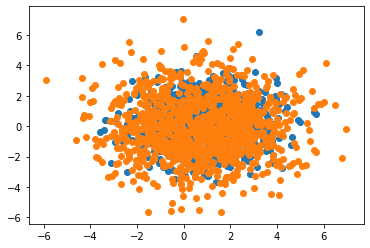

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(theta[:,0],theta[:,1])
plt.scatter(theta_[:,0],theta_[:,1])

In [57]:
def NNE(theta,k=1):
    """
    Parameters:
        theta (Tensor): Samples, NbExemples X NbDimensions   
        k (Int): ordinal number

    Returns:
        (Float) k-Nearest Neighbour Estimation of the entropy of theta  
    
    """
    nb_samples=theta.shape[0]
    dim=theta.shape[1]
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=0, largest=False, sorted=True)[0][k].clamp(torch.finfo().eps,float('inf')).to(device)
    d=torch.as_tensor(float(dim),device=device)
    K=torch.as_tensor(float(k),device=device)
    N=torch.as_tensor(float(nb_samples),device=device)
    pi=torch.as_tensor(math.pi,device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)
    return  - torch.digamma(K) + lcd + d/nb_samples*torch.sum(torch.log(a))+torch.log(N)#+torch.digamma(N)

In [77]:
dim=60
p=torch.distributions.multivariate_normal.MultivariateNormal(torch.randn(dim),covariance_matrix=torch.diagflat(torch.rand(dim).abs()))
p.entropy()


tensor(56.0667)

In [82]:
NNE(p.sample((1,10000)).squeeze(),1)

tensor(69.1525)

In [60]:
torch.digamma(torch.tensor(float(100)))

tensor(4.6002)

In [55]:
import numpy as np
np.log(100)

4.605170185988092